In [1]:
# launch using 'jupyter lab --core-mode'
# Data loading and preproccessing 
import pandas as pd

#Load dataset
df = pd.read_csv('kddcup.data', header=None)

#Assign column names
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']
df.columns = columns

#Inspect data
print(df.head())
print(df.info())

#Preprocess: Binary classification label encoding
df['target'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)
df.drop('label', axis=1, inplace=True)

#encoding for categorical features
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag', 'logged_in'])

# #31-#40 - Host-based traffic features

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        215      45076     0   
1         0           tcp    http   SF        162       4528     0   
2         0           tcp    http   SF        236       1228     0   
3         0           tcp    http   SF        233       2032     0   
4         0           tcp    http   SF        239        486     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   0   
1               0       0    0  ...                   1   
2               0       0    0  ...                   2   
3               0       0    0  ...                   3   
4               0       0    0  ...                   4   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     0.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3           

C:\Users\maz\AppData\Local\Temp\ipykernel_7928\1343863053.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['target'], palette="Set2")
C:\Users\maz\AppData\Local\Temp\ipykernel_7928\1343863053.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Normal (0)", "Attack (1)"], fontsize=11)


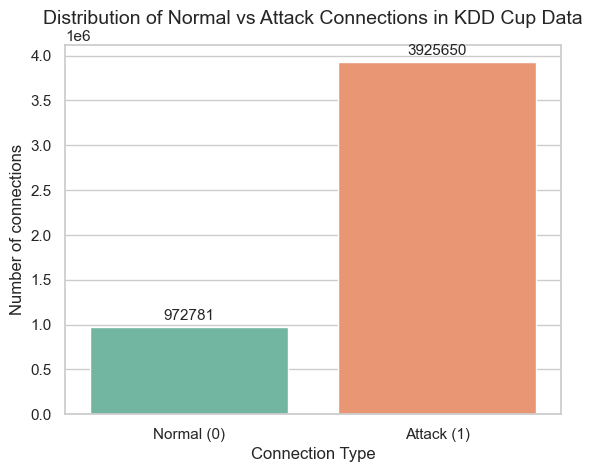

In [2]:
# Exploratory analysis 

import seaborn as sns
import matplotlib.pyplot as plt

#set style
sns.set(style="whitegrid")

#Plot distribution
ax = sns.countplot(x=df['target'], palette="Set2")

#Set title and axis
ax.set_title("Distribution of Normal vs Attack Connections in KDD Cup Data", fontsize=14, pad=15)
ax.set_xlabel("Connection Type", fontsize=12)
ax.set_ylabel("Number of connections", fontsize=12)
ax.set_xticklabels(["Normal (0)", "Attack (1)"], fontsize=11)

#Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=11)

#Show plot
plt.show()

In [3]:
#SVM Classification - classifies network connections from normal or attack based on feature scaling and subsampling for memory efficiency
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

#1 - Define features and target
X = df.drop('target', axis=1)
y = df['target']

#2 - Initial split to reduce size (70/30 split)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#3 - Further subsample 50000 rows training data to manage memory
sample_size = 50000
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_full, y_train_full, train_size=sample_size, random_state=42, stratify=y_train_full
)

#4 - Feature scale
scaler = StandardScaler()
X_train_sampled = scaler.fit_transform(X_train_sampled)
X_test = scaler.transform(X_test)

#5 - Train SVM with timing & logging
print(f"Training SVM on {sample_size} samples...")
start_time = time.time()

svm_model = SVC(class_weight='balanced', kernel='rbf', verbose=True)
svm_model.fit(X_train_sampled, y_train_sampled)

end_time = time.time()
print(f"SVM training complete in {end_time - start_time:.2f} seconds.")



Training SVM on 50000 samples...
[LibSVM]SVM training complete in 2.22 seconds.


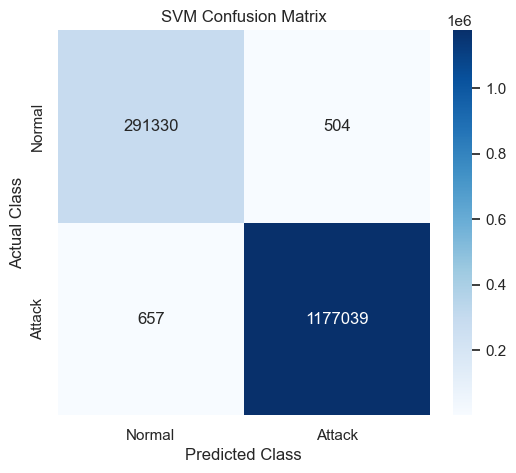

In [4]:
# Confusion matrix heatmap : 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#1) Gain predictions
y_pred_svm = svm_model.predict(X_test)

#2) Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

#3) Plot heatmap:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('SVM Confusion Matrix')
plt.show()

# Results shown in cmd :
#iter = # of optimisation iterations
#nSV = # of Support vectors used to define decision boundary.
#nBSV = # Boundary support vectors
#rho = Model bias term

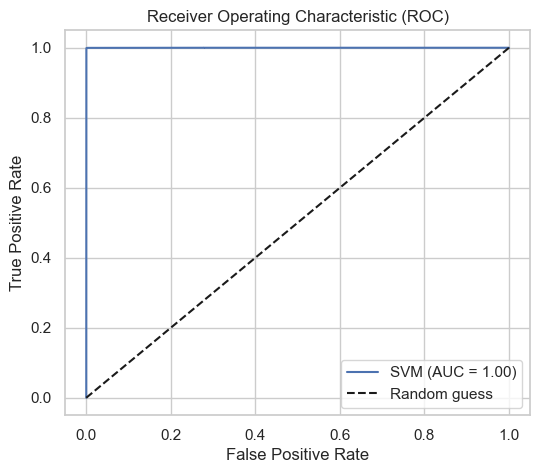

In [5]:
# ROC Curve & AUC - illustrates trade-off between true positive rate and false positive rate across thresholds:

from sklearn.metrics import roc_curve, auc

#1 - Get decision scores
y_score = svm_model.decision_function(X_test)

#2 - Calculate ROC metrics
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#3 - Plot ROC Curve 
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()



C:\Users\maz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Training Gaussian Naive Bayes...
Training completed in 0.06 seconds.
 Gaussian Naive Bayes Classification report 
              precision    recall  f1-score   support

      Normal       1.00      0.08      0.14    291834
      Attack       0.81      1.00      0.90   1177696

    accuracy                           0.82   1469530
   macro avg       0.91      0.54      0.52   1469530
weighted avg       0.85      0.82      0.75   1469530



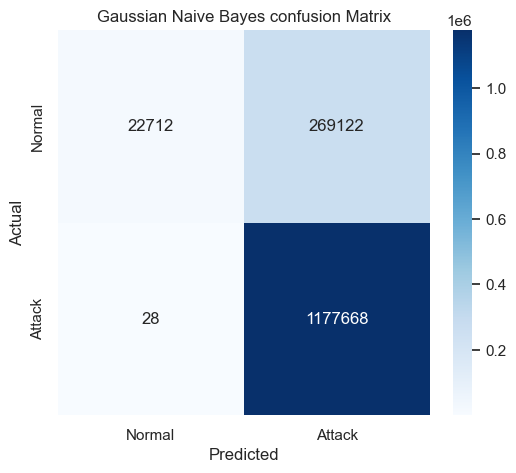

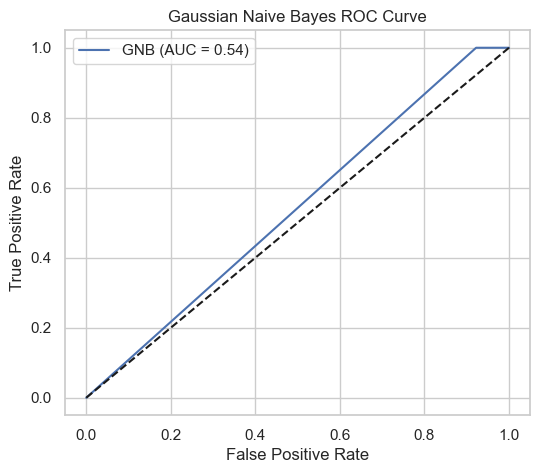

In [15]:
# Naive Bayes Classification - evaluated as probabilistic model to compare with margin-based SVM classifier

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

#Subsample for computational efficiency
sample_size = 50000
X_train_nb, _, y_train_nb, _ = train_test_split(
    X_train_full, y_train_full, train_size=sample_size, random_state=42, stratify=y_train_full
)

#Scale data
scaler_nb = StandardScaler()
X_train_nb_scaled = scaler_nb.fit_transform(X_train_nb)
X_test_nb_scaled = scaler_nb.transform(X_test)

#Train Gaussian Naive Bayes with timing
print("Training Gaussian Naive Bayes...")
start_time = time.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_nb_scaled, y_train_nb)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

#predict and evaluate
y_pred_gnb = gnb_model.predict(X_test_nb_scaled)
y_prob_gnb = gnb_model.predict_proba(X_test_nb_scaled)[:, 1]

#Classification report
print(" Gaussian Naive Bayes Classification report ")
print(classification_report(y_test, y_pred_gnb, target_names=['Normal', 'Attack']))

#Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gnb), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.title('Gaussian Naive Bayes confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_prob_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
plt.figure(figsize=(6, 5))
plt.plot(fpr_gnb, tpr_gnb, label=f'GNB (AUC = {roc_auc_gnb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Gaussian Naive Bayes ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# No analysis of misclassifications or confidence levels, limited handling of class imbalance, relies on stratification but does not apply imbalance techniques.

C:\Users\maz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Training KNN on 50000 samples...
KNN training complete in 0.02 seconds.
=== KNN Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    291834
      Attack       1.00      1.00      1.00   1177696

    accuracy                           1.00   1469530
   macro avg       1.00      1.00      1.00   1469530
weighted avg       1.00      1.00      1.00   1469530



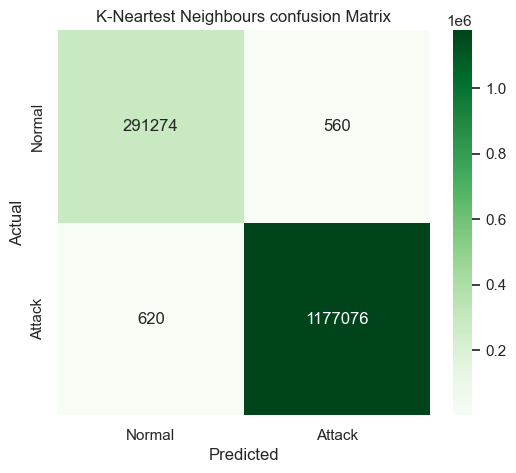

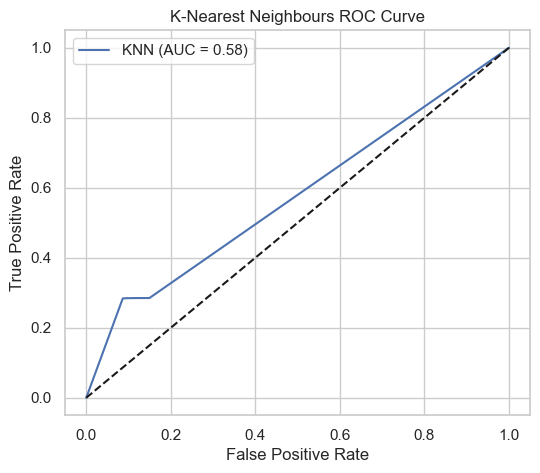

In [11]:
# K-Nearest Neighbours (KNN) Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Subsample to manage execution cost
sample_size = 50000
X_train_knn, _, y_train_knn, _ = train_test_split(
    X_train_full, y_train_full, train_size=sample_size, random_state=42, stratify=y_train_full
)

#Scale data
X_train_knn_scaled = scaler.fit_transform(X_train_knn)
X_test_knn_scaled = scaler.transform(X_test)

#Training
print("Training KNN on 50000 samples...")
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_knn_scaled, y_train_knn)
end_time = time.time()
print(f"KNN training complete in {end_time - start_time:.2f} seconds.")

# predictions
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test_knn_scaled)[:, 1]

#Classification report
print(" KNN Classification Report ")
print(classification_report(y_test, y_pred_knn, target_names=['Normal', 'Attack']))

#Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.title('K-Nearest Neighbours confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(6, 5))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('K-Nearest Neighbours ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

C:\Users\maz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Training isolation forest on 50000 samples (unsupervised)... 
Isolation forest training complete in 0.32 seconds.
Isolation forest classification report
              precision    recall  f1-score   support

      Normal       0.19      0.93      0.31    291834
      Attack       0.29      0.01      0.01   1177696

    accuracy                           0.19   1469530
   macro avg       0.24      0.47      0.16   1469530
weighted avg       0.27      0.19      0.07   1469530



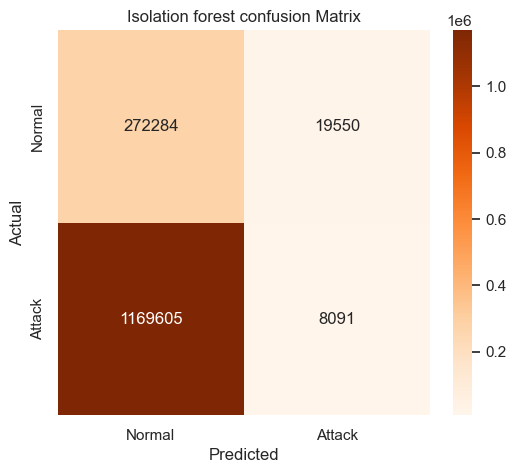

In [13]:
# Isolation Forest anomaly detection

from sklearn.ensemble import IsolationForest
import numpy as np

# same subsample for fair computational cost and comparabiliy
X_train_iso, _, _, _ = train_test_split(X_train_full, y_train_full, train_size=sample_size, random_state=42, stratify=y_train_full)
X_train_iso_scaled = scaler.fit_transform(X_train_iso)
X_test_iso_scaled = scaler.transform(X_test)

# Train isolation forest
print("Training isolation forest on 50000 samples (unsupervised)... ")
start_time = time.time()
iso_model = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
iso_model.fit(X_train_iso_scaled)
end_time = time.time()
print(f"Isolation forest training complete in {end_time - start_time:.2f} seconds.")

# Predict anomalies (-1 = anomaly, 1 = normal)
y_pred_iso = iso_model.predict(X_test_iso_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0) # convert -1 to 1 (attack), 1 to 0 (normal)

# classification report
print("---Isolation forest classification report---")
print(classification_report(y_test, y_pred_iso, target_names=['Normal', 'Attack']))

# confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_iso), annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
plt.title('Isolation forest confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
### Model Performance Summary

# SVM - highly accurate, perfect separation on ROC, high computational costs, & best used for offline training, high-security environments 
# Naive Bayes - fast, low memory, improved PCA, but sensitive to feature scaling, naive assumptions, best for real-time low-resource environments
# KNN - no training costs, also good with PCA, but high prediction costs, sensitive to noise, and best used for small datasets, or as a benchmark
# Isolation forest - unsupervised, detects unkwown attacks, but limited to binary anomaly labels, zero-day anomaly detection 
